In [140]:
import numpy as np
import scipy
from skimage import data, io, color, transform, exposure
import matplotlib.pyplot as plt

%matplotlib inline
# notebook
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = (32.0, 24.0)
pylab.rcParams['font.size'] = 24

In [52]:
# loading the data and doing the 2d Fourier transform on it
train_amt = 10

trainS = [io.imread("S" + str(i+1) + ".GIF") for i in range(train_amt)]
trainT = [io.imread("T" + str(i+1) + ".GIF") for i in range(train_amt)]
trainV = [io.imread("V" + str(i+1) + ".GIF") for i in range(train_amt)]

trainSFourier = [np.fft.fft2(trainS[i]) for i in range(train_amt)]
trainTFourier = [np.fft.fft2(trainT[i]) for i in range(train_amt)]
trainVFourier = [np.fft.fft2(trainV[i]) for i in range(train_amt)]

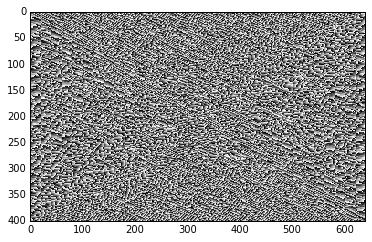

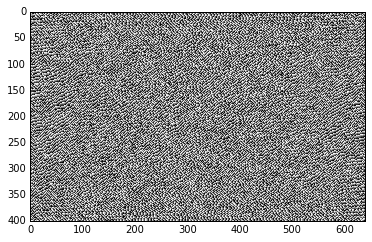

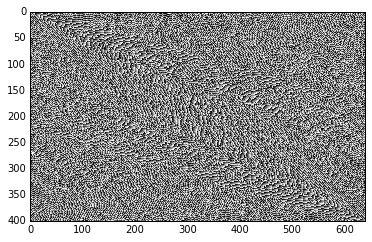

In [65]:
ax_im = io.imshow(np.angle(trainSFourier[0]))
io.show()
ax_im = io.imshow(np.angle(trainTFourier[0]))
io.show()
ax_im = io.imshow(np.angle(trainVFourier[0]))
io.show()

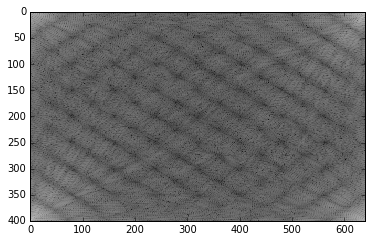

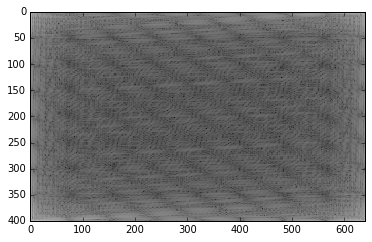

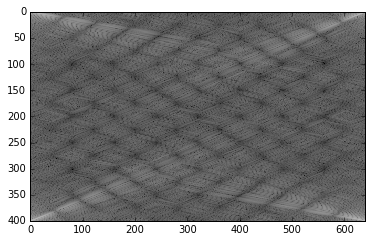

In [66]:
ax_im = io.imshow(np.log(np.abs(trainSFourier[i]) + 1))
io.show()
ax_im = io.imshow(np.log(np.abs(trainTFourier[i]) + 1))
io.show()
ax_im = io.imshow(np.log(np.abs(trainVFourier[i]) + 1))
io.show()

[98844.0149574  98551.02466792 98215.61591657 98583.00617778
 98768.89664886 98551.02466792 98733.90873924 98502.01573545
 98712.84800261 98521.36406052]
[1394334.14960952 1212152.13331907 1145474.06983497 1202253.78444108
 1218765.77513603 1212152.13331907 1234500.36247715 1415131.20822795
 1401844.69768935 1164146.41504442]


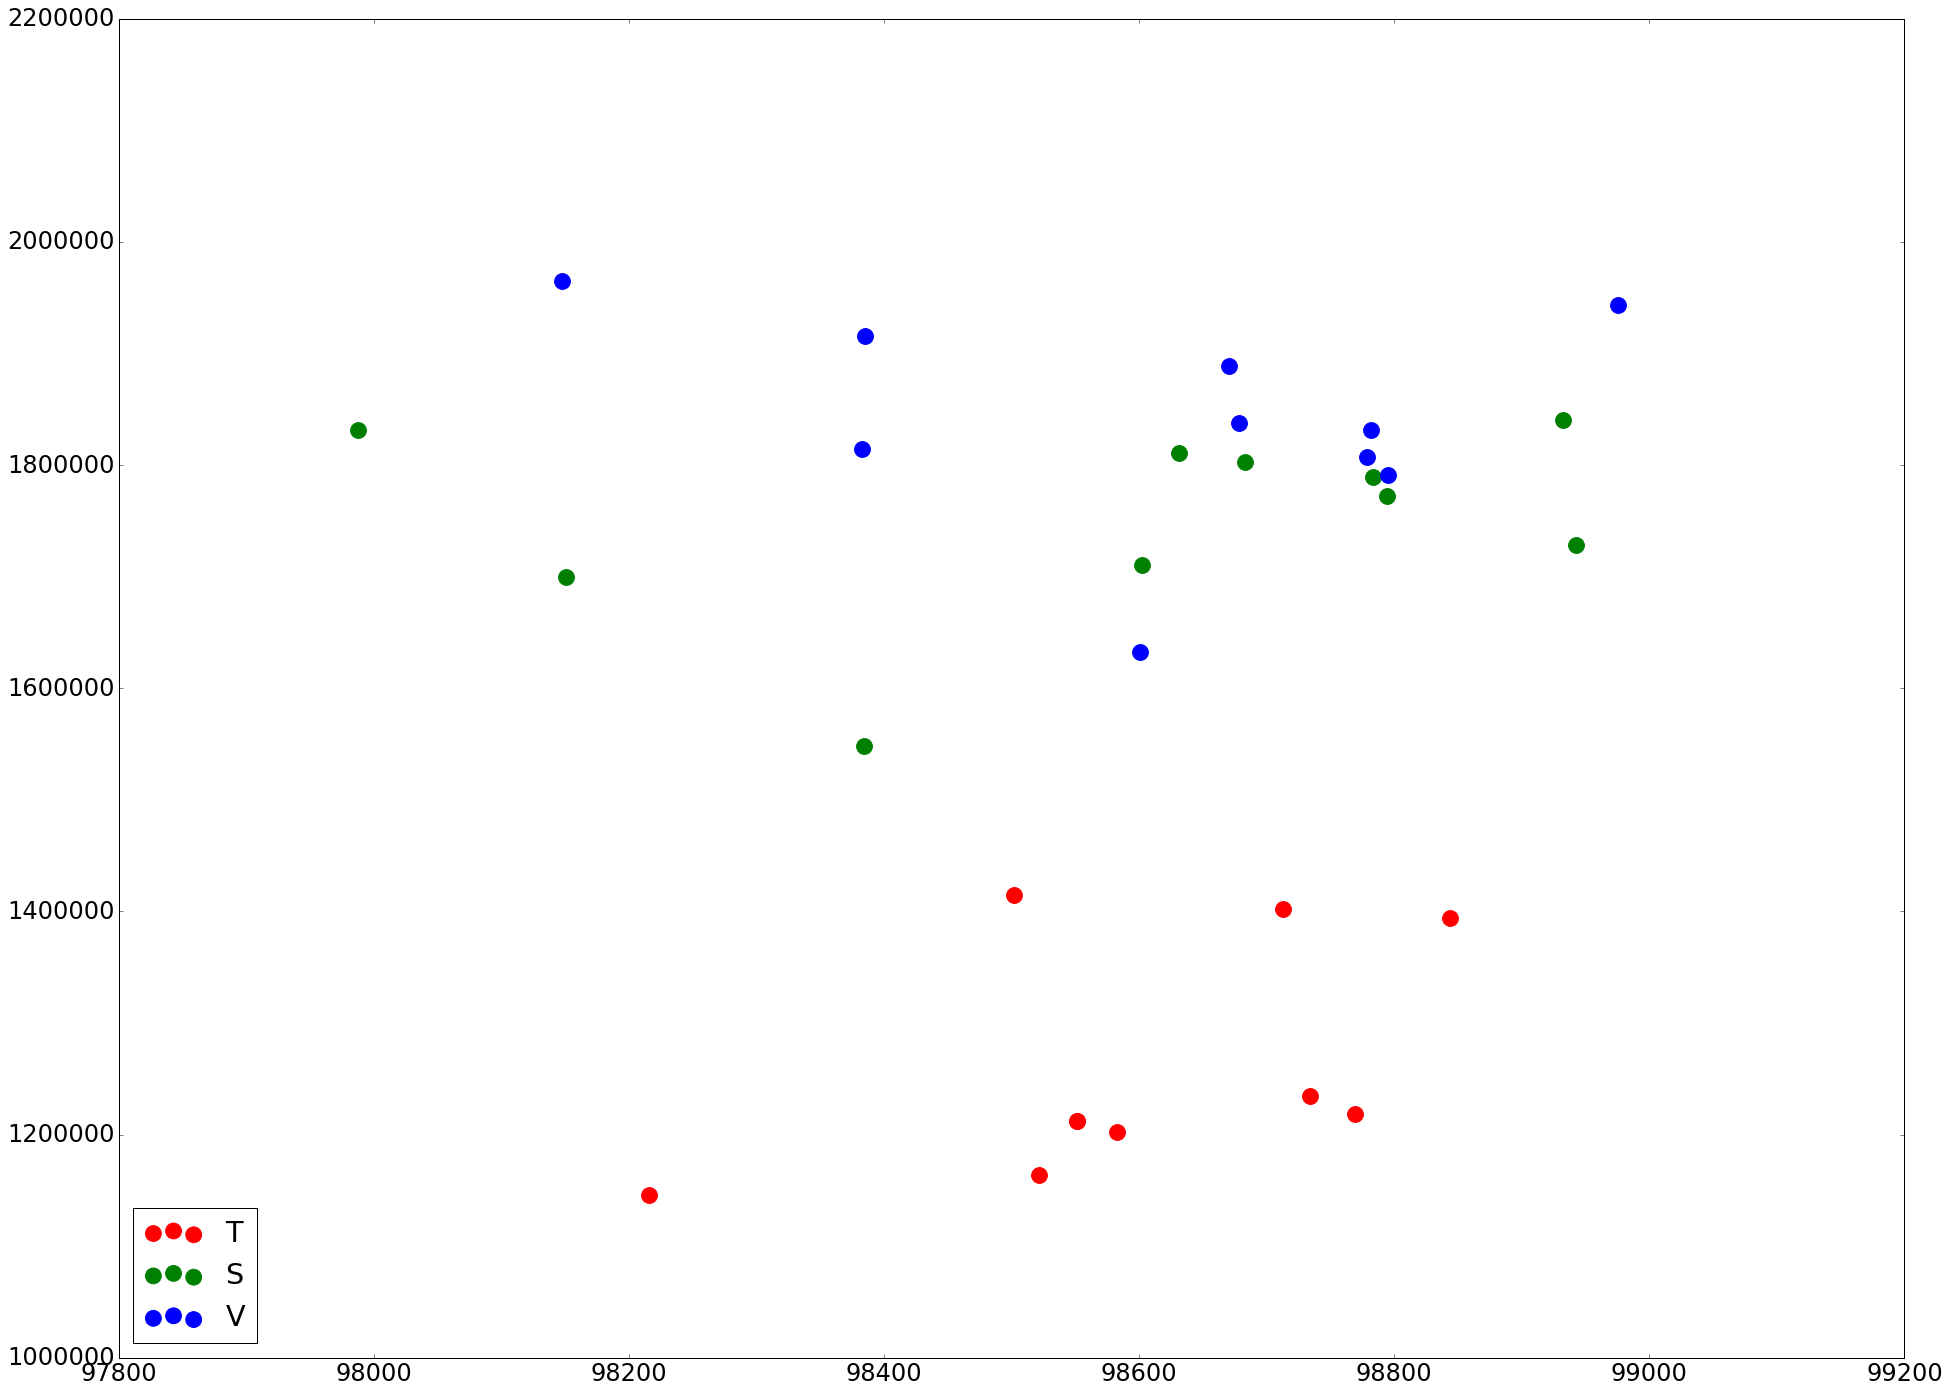

In [146]:
d = (np.angle(trainTFourier[8]))
def boxpass(fourierList):
    s = 0
    for r in range(100, 300):
        for t in range(225, 375):
            s += fourierList[r, t]**2
    return s

feature1 = np.array([boxpass(np.angle(trainTFourier[i])) for i in range(train_amt)])
feature2 = np.array([boxpass(np.log(np.abs(trainTFourier[i]) + 1)) for i in range(train_amt)])
feature3 = np.array([boxpass(np.angle(trainSFourier[i])) for i in range(train_amt)])
feature4 = np.array([boxpass(np.log(np.abs(trainSFourier[i]) + 1)) for i in range(train_amt)])
feature5 = np.array([boxpass(np.angle(trainVFourier[i])) for i in range(train_amt)])
feature6 = np.array([boxpass(np.log(np.abs(trainVFourier[i]) + 1)) for i in range(train_amt)])



print(feature1)
print(feature2)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(feature1, feature2, s=250, color="r", label="T")
ax.scatter(feature3, feature4, s=250, color="g", label="S")
ax.scatter(feature5, feature6, s=250, color="b", label="V")
ax.legend(loc=3)
plt.show()

#Use ring and box since they are invariant of letter positioning